In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

# Create a SparkSession
spark = SparkSession.builder.appName("App").getOrCreate()
spark.sparkContext.setLogLevel("WARN")

24/01/07 21:54:14 WARN Utils: Your hostname, andreas-HP-Pavilion-Laptop-15-cs1xxx resolves to a loopback address: 127.0.1.1; using 192.168.1.61 instead (on interface wlo1)
24/01/07 21:54:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/07 21:54:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load CSV File with Header

In [2]:
# Load the CSV file with the first row as a header
df = spark.read.format("csv").option("delimiter", ",").option("header", "true").load("1987.csv")

# Display the columns and the first 15 rows
df.show(15, truncate=False)

24/01/07 21:54:46 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|1987|10   |14        |3        |741    |730       |912    |849       |PS           |1451     

In [3]:
# Iterate over all columns in the DataFrame
for column in df.columns:
    df = df.withColumn(column, when(col(column) == "NA", None).otherwise(col(column)))

df.show()

+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance|TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|1987|   10|        14|        3|    741|       730|    912|       849|           PS|     1451

In [4]:
from pyspark.sql.functions import col

# Counts the number of null values for each column
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+-------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|Year|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|ArrTime|CRSArrTime|UniqueCarrier|FlightNum|TailNum|ActualElapsedTime|CRSElapsedTime|AirTime|ArrDelay|DepDelay|Origin|Dest|Distance| TaxiIn|TaxiOut|Cancelled|CancellationCode|Diverted|CarrierDelay|WeatherDelay|NASDelay|SecurityDelay|LateAircraftDelay|
+----+-----+----------+---------+-------+----------+-------+----------+-------------+---------+-------+-----------------+--------------+-------+--------+--------+------+----+--------+-------+-------+---------+----------------+--------+------------+------------+--------+-------------+-----------------+
|   0|    0|         0|        0|  19685|         0|  23500|         0|            0|      

# Preprocessing
- eliminate unnecesary variables
- missing and duplicates values
- see correlation
- variable transformation
- variable creation

In [5]:
# columns to eliminate
columns = [
    "ArrTime", 
    "ActualElapsedTime", 
    "AirTime", 
    "TaxiIn", 
    "Diverted", 
    "CarrierDelay", 
    "WeatherDelay", 
    "NASDelay", 
    "SecurityDelay", 
    "LateAircraftDelay"
]

# Eliminate columns
df = df.drop(*columns)


In [6]:
# columns to eliminate
columns = [
    "Year",
    "TailNum",
    "TaxiOut",
    "Cancelled",
    "CancellationCode"  
]

# Eliminate columns
df = df.drop(*columns)

## Missing values

In [7]:
# Contar valores NA por columna
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----+----------+---------+-------+----------+----------+-------------+---------+--------------+--------+--------+------+----+--------+
|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|CRSArrTime|UniqueCarrier|FlightNum|CRSElapsedTime|ArrDelay|DepDelay|Origin|Dest|Distance|
+-----+----------+---------+-------+----------+----------+-------------+---------+--------------+--------+--------+------+----+--------+
|    0|         0|        0|  19685|         0|         0|            0|        0|             0|   23500|   19685|     0|   0|    1015|
+-----+----------+---------+-------+----------+----------+-------------+---------+--------------+--------+--------+------+----+--------+


#Now we check if NA stands for 0. If this value is not present, means that NA was 0.

In [8]:
from pyspark.sql import functions as F
# Filter the DataFrame to keep only rows where ArrDelay is equal to 0
filtered_df = df.filter(F.col("ArrDelay") == 0)

# Total number of rows in the DataFrame
total_rows = df.count()

# Check if there are any rows in the filtered DataFrame
if filtered_df.count() > 0:
    print("0 is present in the ArrDelay column " + str(filtered_df.count()) + " times out of " + str(total_rows) + ".")
else:
    print("0 is not present in the ArrDelay column.")

0 is present in the ArrDelay column 60436 times out of 1311826.


In [9]:
# Calculate the percentage of null values for each column
null_percentage = df.select([(count(when(col(c).isNull(), c)) / total_rows).alias(c) for c in df.columns])

# Show the percentage of null values for each column
null_percentage.show()

+-----+----------+---------+--------------------+----------+----------+-------------+---------+--------------+--------------------+--------------------+------+----+--------------------+
|Month|DayofMonth|DayOfWeek|             DepTime|CRSDepTime|CRSArrTime|UniqueCarrier|FlightNum|CRSElapsedTime|            ArrDelay|            DepDelay|Origin|Dest|            Distance|
+-----+----------+---------+--------------------+----------+----------+-------------+---------+--------------+--------------------+--------------------+------+----+--------------------+
|  0.0|       0.0|      0.0|0.015005801074227831|       0.0|       0.0|          0.0|      0.0|           0.0|0.017913961150335486|0.015005801074227831|   0.0| 0.0|7.737306624506603E-4|
+-----+----------+---------+--------------------+----------+----------+-------------+---------+--------------+--------------------+--------------------+------+----+--------------------+


In [10]:
# Drop rows with at least one missing value

df = df.dropna()
dropped_rows = total_rows - df.count()
print("Dropped "+ str(dropped_rows)+ " rows.")

Dropped 24493 rows.


## Duplicates

In [11]:
# Check for duplicates and show the results
total_rows = df.count()
df = df.dropDuplicates()

if total_rows - df.count()  > 0:
    print("There are duplicates in the DataFrame.")
else:
    print("No duplicates found in the DataFrame.")

There are duplicates in the DataFrame.


## Variable transformation

In [12]:
# List of columns to exclude from conversion
exclude_columns = ['UniqueCarrier', 'Origin', 'Dest']

# Convert all columns to integer type except the ones in exclude_columns
for column in df.columns:
    if column not in exclude_columns:
        df = df.withColumn(column, col(column).cast("integer"))

# Display the columns and the first 15 rows to verify the change
df.show(15, truncate=False)



+-----+----------+---------+-------+----------+----------+-------------+---------+--------------+--------+--------+------+----+--------+
|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|CRSArrTime|UniqueCarrier|FlightNum|CRSElapsedTime|ArrDelay|DepDelay|Origin|Dest|Distance|
+-----+----------+---------+-------+----------+----------+-------------+---------+--------------+--------+--------+------+----+--------+
|10   |10        |6        |1635   |1635      |1732      |PS           |1454     |57            |8       |0       |OAK   |BUR |325     |
|10   |20        |2        |1945   |1945      |2101      |PS           |1484     |76            |1       |0       |SFO   |SAN |447     |
|10   |9         |5        |2057   |2016      |2132      |PS           |1486     |76            |47      |41      |OAK   |SAN |446     |
|10   |13        |2        |2114   |2115      |2223      |PS           |1505     |68            |3       |-1      |SNA   |SJC |342     |
|10   |18        |7        |841    |842  

In [13]:
# Print distinct values for each specified column
for column in exclude_columns:
    print(f"Distinct values in column '{column}':")
    distinct_values = df.select(column).distinct().collect()
    for value in distinct_values:
        print(value[column])
    print("\n")  # Adding a newline for better readability
    # Print the number of elements in the distinct_values list
    print(f"Number of distinct values: {len(distinct_values)}")

Distinct values in column 'UniqueCarrier':


UA
EA
PS
NW
HP
TW
WN
PI
AA
DL
CO
PA (1)
US
AS


Number of distinct values: 14
Distinct values in column 'Origin':


MSY
GEG
BUR
SNA
GTF
GRB
GRR
EUG
GSO
PVD
OAK
MSN
FAR
DCA
CID
RDM
LEX
ORF
CRW
SAV
CMH
CAK
MOB
PNS
LIH
IAH
HNL
ERI
SHV
SJC
CVG
TOL
LGA
BUF
TLH
HPN
RDD
AUS
MLI
SJU
ATW
LGB
GJT
BFL
GFK
RNO
SRQ
SBN
RST
CHS
TUL
RSW
HRL
ISP
AMA
BOS
MAF
MLB
EWR
LAS
BIS
FAI
JAN
DLH
DEN
ALB
CPR
LNK
IAD
PSP
SBA
BOI
DRO
SEA
CMI
LAN
MCI
FLG
BNA
CLT
PSC
BLI
ABQ
PBI
SDF
SCK
ACV
MRY
BDL
DAL
CLE
PDX
MFR
MIA
ILG
TPA
BWI
OKC
SMF
MBS
PHX
STL
PWM
DFW
MHT
ABE
GSP
LSE
STX
LMT
LBB
CRP
FSD
SFO
MEM
ELP
GCN
BHM
YKM
FLL
ATL
RIC
DAY
OMA
VPS
LIT
FAT
ICT
CAE
ORD
AVP
BTV
BIL
ILM
PUB
PIA
RDU
MKE
CCR
SYR
HSV
TUS
PIT
MDW
AZO
COS
IND
ALO
KOA
EAU
GPT
MGM
DTW
HOU
TYS
CHA
YUM
ONT
MDT
FWA
JAX
LAX
MSP
MOT
BGR
BTR
MCO
SGF
ROC
SAN
BZN
JFK
ANC
SUX
DAB
GNV
MSO
PHL
OGG
DSM
FOE
SAT
SLC
STT
RAP
BGM
IDA
MYR
ISO
BTM
MLU
HLN
EVV
CWA
TRI
SPN
UCA
CHO
AVL
LYH
EYW
JAC
ORH
ITH
APF
ROA
YAP
ELM
FCA
FAY
CSG
FNT
PFN
GUM
MFE
LFT
OAJ
JNU
HTS
AGS
ROR
PSG
SCC
WRG
CDV
OME
PIE
TVL
BET
PHF
SIT
OTZ
YAK
GUC
PIR
HDN


Number of distinct values: 236
Distinct values in colu

MSY
GEG
BUR
SNA
GTF
GRB
GRR
EUG
PVD
GSO
OAK
MSN
FAR
DCA
CID
RDM
LEX
ORF
EVV
CRW
CWA
SAV
CMH
CAK
MOB
PNS
LIH
IAH
HNL
ERI
SHV
SJC
CVG
TOL
LGA
BUF
TLH
HPN
RDD
MLI
AUS
SJU
ATW
LGB
GJT
BFL
GFK
RNO
SRQ
SBN
RST
CHS
TUL
RSW
HRL
ISP
AMA
BOS
MAF
MLB
EWR
LAS
BIS
FAI
JAN
DLH
DEN
ALB
CPR
LNK
IAD
PSP
BOI
SBA
DRO
SEA
CMI
MCI
FLG
BNA
CLT
BLI
PSC
ABQ
PBI
SDF
SCK
ACV
MRY
BDL
DAL
CLE
PDX
MFR
MIA
ILG
BWI
TPA
OKC
SMF
MBS
PHX
STL
PWM
DFW
ABE
MHT
GSP
LSE
STX
LMT
LBB
CRP
FSD
SFO
MEM
ELP
GCN
BHM
YKM
FLL
ATL
RIC
DAY
OMA
VPS
LIT
FAT
ICT
CAE
ORD
AVP
BTV
BIL
ILM
PUB
PIA
RDU
MKE
CCR
SYR
HSV
TUS
PIT
MDW
AZO
COS
IND
ALO
KOA
EAU
GPT
MGM
DTW
HOU
TYS
CHA
YUM
ONT
MDT
FWA
JAX
LAX
MSP
MOT
BGR
BTR
MCO
SGF
ROC
SAN
BZN
JFK
ANC
SUX
DAB
MSO
PHL
OGG
DSM
FOE
SAT
SLC
STT
RAP
BGM
IDA
MYR
ISO
BTM
MLU
HLN
TRI
SPN
UCA
CHO
AVL
LYH
EYW
JAC
LAN
ORH
ITH
APF
ROA
YAP
ELM
FCA
FAY
CSG
FNT
PFN
GUM
MFE
LFT
OAJ
JNU
HTS
AGS
ROR
GNV
PSG
SCC
WRG
CDV
OME
PIE
TVL
BET
PHF
SIT
OTZ
YAK
GUC
HDN
PIH


Number of distinct values: 236


## Import geographic coordinates

In [14]:
# Read the CSV file
usa_airport_df = spark.read.csv("us-airports.csv", header=True)

# Select only the 'latitude_deg', 'longitude_deg', and 'iata_code' columns
usa_airport_df = usa_airport_df.select("latitude_deg", "longitude_deg", "iata_code")

usa_airport_df.show()

+----------------+-----------------+---------+
|    latitude_deg|    longitude_deg|iata_code|
+----------------+-----------------+---------+
|       33.942501|      -118.407997|      LAX|
|         41.9786|         -87.9048|      ORD|
|       40.639447|       -73.779317|      JFK|
|         33.6367|       -84.428101|      ATL|
|37.6189994812012|         -122.375|      SFO|
|       40.692501|       -74.168701|      EWR|
|       32.896801|       -97.038002|      DFW|
|       36.083361|      -115.151817|      LAS|
|28.4293994903564|-81.3089981079102|      MCO|
| 39.861698150635|   -104.672996521|      DEN|
|         38.9445|       -77.455803|      IAD|
|       40.777199|       -73.872597|      LGA|
|25.7931995391846|-80.2906036376953|      MIA|
|       33.435302|      -112.005905|      PHX|
|       47.449162|      -122.311134|      SEA|
|         42.3643|       -71.005203|      BOS|
| 39.871898651123| -75.241096496582|      PHL|
|35.2140007019043|-80.9430999755859|      CLT|
|29.984399795

In [16]:
# Select and concatenate the values from 'Origin' and 'Destination' columns
origin = df.select("Origin").distinct()
destination = df.select("Dest").distinct()

all_airports = origin.distinct().union(destination)

# Get distinct values
distinct_airports = all_airports.distinct()
print(all_airports.count())



# Collect the distinct values

#Distinct airport codes in the new Dataset.
usa_iata_codes = usa_airport_df.select("iata_code").distinct()


#Show the missing values

distinct_airports.subtract(usa_iata_codes).show()


472


+------+
|Origin|
+------+
|   SPN|
|   UCA|
|   SJU|
|   YAP|
|   STX|
|   PFN|
|   GUM|
|   ROR|
|   STT|
+------+


In [20]:
import re

# Function to convert DMS (degrees, minutes, seconds) to DD (decimal degrees)
def dms_to_dd(dms):
    parts = re.split('[°′″]', dms)
    degrees = float(parts[0])
    minutes = float(parts[1])
    seconds = float(parts[2])
    direction = parts[3]
    
    dd = degrees + minutes/60 + seconds/3600
    if direction in ('S', 'W'):
        dd *= -1
    return dd

# Coordinates in DMS format with corresponding  codes
coordinates = [
    ("43°08′36″N", "075°22′48″W","UCA"),
    ("18°20′14″N", "064°58′24″W","STT"),
    ("7°22′02″N", "134°32′39″E","ROR"),
    ("17°42′16″N", "64°48′06″W","STX"),
    ("9°29′56″N", "138°04′57″E","YAP"),
    ("13°29′02″N", "144°47′50″W","GUM"),
    ("15°07′08″N", "145°43′46″E","SPN"),
    ("30°12′44″N", "085°40′58″W","PFN"),
    ("18°26′22″N", "66°00′07″W","SJU")
]

# Convert the DMS coordinates to decimal degrees
airport_coordinates_dd = [(dms_to_dd(lat), dms_to_dd(lon),code) for  lat, lon ,code in coordinates]

new_airports_df = spark.createDataFrame(airport_coordinates_dd, ["latitude_deg", "longitude_deg", "iata_code"])
new_airports_df.show()

usa_airport_df = usa_airport_df.union(new_airports_df).distinct()

+------------------+-------------------+---------+
|      latitude_deg|      longitude_deg|iata_code|
+------------------+-------------------+---------+
| 43.14333333333333|             -75.38|      UCA|
| 18.33722222222222| -64.97333333333333|      STT|
| 7.367222222222222| 134.54416666666665|      ROR|
|17.704444444444444| -64.80166666666666|      STX|
| 9.498888888888889|           138.0825|      YAP|
|13.483888888888888|-144.79722222222222|      GUM|
| 15.11888888888889| 145.72944444444445|      SPN|
| 30.21222222222222| -85.68277777777779|      PFN|
|18.439444444444444| -66.00194444444445|      SJU|
+------------------+-------------------+---------+


In [22]:
#Check that now we have coordinates for each airport
distinct_airports.subtract(usa_airport_df.select("iata_code")).show()

+------+
|Origin|
+------+
+------+


In [23]:
# Now we merge the two dataframes
flights_with_origin = df.join(usa_airport_df, df["Origin"] == usa_airport_df["iata_code"])
flights_with_origin = flights_with_origin.withColumnRenamed("latitude_deg", "Origin_Lat").withColumnRenamed("longitude_deg", "Origin_Long")

flights_with_origin.show()


+-----+----------+---------+-------+----------+----------+-------------+---------+--------------+--------+--------+------+----+--------+-----------+------------+---------+
|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|CRSArrTime|UniqueCarrier|FlightNum|CRSElapsedTime|ArrDelay|DepDelay|Origin|Dest|Distance| Origin_Lat| Origin_Long|iata_code|
+-----+----------+---------+-------+----------+----------+-------------+---------+--------------+--------+--------+------+----+--------+-----------+------------+---------+
|   10|        21|        3|    723|       720|       817|           PI|      759|            57|      13|       3|   BGM| BWI|     212|42.20869827|-75.97979736|      BGM|
|   10|        30|        5|    720|       720|       817|           PI|      759|            57|       4|       0|   BGM| BWI|     212|42.20869827|-75.97979736|      BGM|
|   10|         7|        3|   1525|      1525|      1545|           PI|      930|            20|      -5|       0|   BGM| ITH|      32|42.2

In [24]:
#adding destination coordinates
usa_airport_df = usa_airport_df.distinct()
flights_with_dest = flights_with_origin.join(usa_airport_df, flights_with_origin["Dest"] == usa_airport_df["iata_code"])
flights_with_dest = flights_with_dest.withColumnRenamed("latitude_deg", "Dest_Lat").withColumnRenamed("longitude_deg", "Dest_Long")

flights_with_dest.show()


+-----+----------+---------+-------+----------+----------+-------------+---------+--------------+--------+--------+------+----+--------+-----------+------------+---------+----------------+-----------------+---------+
|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|CRSArrTime|UniqueCarrier|FlightNum|CRSElapsedTime|ArrDelay|DepDelay|Origin|Dest|Distance| Origin_Lat| Origin_Long|iata_code|        Dest_Lat|        Dest_Long|iata_code|
+-----+----------+---------+-------+----------+----------+-------------+---------+--------------+--------+--------+------+----+--------+-----------+------------+---------+----------------+-----------------+---------+
|   10|        21|        3|    723|       720|       817|           PI|      759|            57|      13|       3|   BGM| BWI|     212|42.20869827|-75.97979736|      BGM|         39.1754|       -76.668297|      BWI|
|   10|        30|        5|    720|       720|       817|           PI|      759|            57|       4|       0|   BGM| BWI|     

In [25]:
#Now we have the coordinates of the airports instead of the codes.

merged_df = flights_with_dest.drop("iata_code","Origin","Dest")

merged_df.show()

+-----+----------+---------+-------+----------+----------+-------------+---------+--------------+--------+--------+--------+-----------+------------+----------------+-----------------+
|Month|DayofMonth|DayOfWeek|DepTime|CRSDepTime|CRSArrTime|UniqueCarrier|FlightNum|CRSElapsedTime|ArrDelay|DepDelay|Distance| Origin_Lat| Origin_Long|        Dest_Lat|        Dest_Long|
+-----+----------+---------+-------+----------+----------+-------------+---------+--------------+--------+--------+--------+-----------+------------+----------------+-----------------+
|   10|        21|        3|    723|       720|       817|           PI|      759|            57|      13|       3|     212|42.20869827|-75.97979736|         39.1754|       -76.668297|
|   10|        30|        5|    720|       720|       817|           PI|      759|            57|       4|       0|     212|42.20869827|-75.97979736|         39.1754|       -76.668297|
|   10|         7|        3|   1525|      1525|      1545|           PI|   

## Use OneHotEncoder for UniqueCarrier

In [26]:
#Now we transform the 'UniqueCarrrier' feature in a OneHotEncoder

from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# Create a StringIndexer
indexer = StringIndexer(inputCol="UniqueCarrier", outputCol="UniqueCarrierIndex")

# Fit the indexer to the DataFrame and transform it
df_indexed = indexer.fit(merged_df).transform(merged_df)

# Create a OneHotEncoder
encoder = OneHotEncoder(inputCols=["UniqueCarrierIndex"], outputCols=["UniqueCarrierVec"])

# Apply the encoder to the DataFrame
df_encoded = encoder.fit(df_indexed).transform(df_indexed)
df_encoded.select("UniqueCarrier", "UniqueCarrierVec").distinct().show(truncate=False)


+-------------+----------------+
|UniqueCarrier|UniqueCarrierVec|
+-------------+----------------+
|US           |(13,[7],[1.0])  |
|EA           |(13,[6],[1.0])  |
|PS           |(13,[11],[1.0]) |
|AS           |(13,[12],[1.0]) |
|NW           |(13,[5],[1.0])  |
|CO           |(13,[3],[1.0])  |
|UA           |(13,[2],[1.0])  |
|PA (1)       |(13,[],[])      |
|DL           |(13,[0],[1.0])  |
|TW           |(13,[8],[1.0])  |
|HP           |(13,[10],[1.0]) |
|PI           |(13,[4],[1.0])  |
|WN           |(13,[9],[1.0])  |
|AA           |(13,[1],[1.0])  |
+-------------+----------------+


In [27]:
#Print Results
df_encoded.select("UniqueCarrier", "UniqueCarrierVec").distinct().show(truncate=False)

+-------------+----------------+
|UniqueCarrier|UniqueCarrierVec|
+-------------+----------------+
|US           |(13,[7],[1.0])  |
|EA           |(13,[6],[1.0])  |
|PS           |(13,[11],[1.0]) |
|AS           |(13,[12],[1.0]) |
|NW           |(13,[5],[1.0])  |
|CO           |(13,[3],[1.0])  |
|UA           |(13,[2],[1.0])  |
|PA (1)       |(13,[],[])      |
|DL           |(13,[0],[1.0])  |
|TW           |(13,[8],[1.0])  |
|HP           |(13,[10],[1.0]) |
|PI           |(13,[4],[1.0])  |
|WN           |(13,[9],[1.0])  |
|AA           |(13,[1],[1.0])  |
+-------------+----------------+


In [44]:
final_df = df_encoded.drop("UniqueCarrier")


# Convert "Origini_Lat" from string to double
final_df = final_df.withColumn("Origin_Lat", final_df["Origin_Lat"].cast("double"))

# Convert "Origini_Long" from string to double
final_df = final_df.withColumn("Origin_Long", final_df["Origin_Long"].cast("double"))

# Convert "Dest_Lat" from string to double
final_df = final_df.withColumn("Dest_Lat", final_df["Dest_Lat"].cast("double"))

# Convert "Dest_Long" from string to double
final_df = final_df.withColumn("Dest_Long", final_df["Dest_Long"].cast("double"))



## Plot to check the coordinates values

In [29]:
# Plot the coordinates to inspect data
lat_long_df = final_df.select("Origin_Lat", "Origin_Long").toPandas()

Origin_Lat     float64
Origin_Long    float64
dtype: object


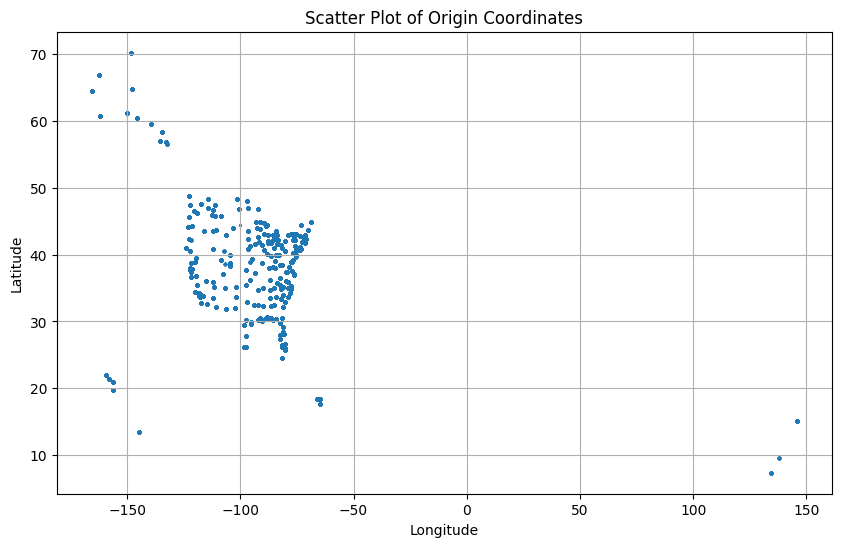

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
# Taking a random sample of the data if it's too large
sample_df = lat_long_df.sample(frac=1)  # Adjust frac as needed

# Convert the 'Origin_Lat' and 'Origin_Long' columns to numeric (floats)
sample_df['Origin_Lat'] = pd.to_numeric(sample_df['Origin_Lat'], errors='coerce')
sample_df['Origin_Long'] = pd.to_numeric(sample_df['Origin_Long'], errors='coerce')

# Check the conversion
print(sample_df.dtypes)

# Now create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x=sample_df["Origin_Long"], y=sample_df["Origin_Lat"], alpha=1,s=2)
plt.title("Scatter Plot of Origin Coordinates")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

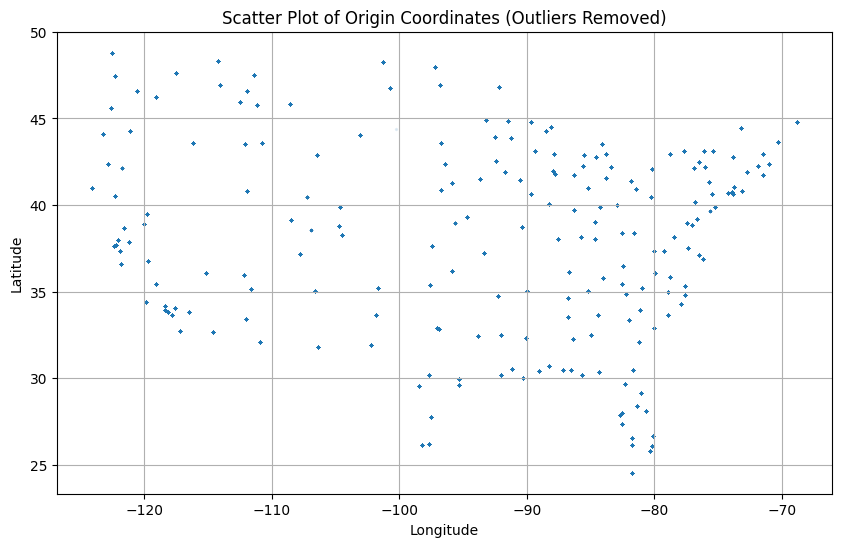

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named sample_df and has been converted to numeric types

# Calculate Q1, Q3, and IQR for Latitude
Q1_lat = sample_df['Origin_Lat'].quantile(0.25)
Q3_lat = sample_df['Origin_Lat'].quantile(0.75)
IQR_lat = Q3_lat - Q1_lat

# Calculate Q1, Q3, and IQR for Longitude
Q1_long = sample_df['Origin_Long'].quantile(0.25)
Q3_long = sample_df['Origin_Long'].quantile(0.75)
IQR_long = Q3_long - Q1_long

# Define bounds for outliers
lower_bound_lat = Q1_lat - 1.5 * IQR_lat
upper_bound_lat = Q3_lat + 1.5 * IQR_lat
lower_bound_long = Q1_long - 1.5 * IQR_long
upper_bound_long = Q3_long + 1.5 * IQR_long

# Filter out outliers
filtered_df = sample_df[(sample_df['Origin_Lat'] >= lower_bound_lat) & 
                        (sample_df['Origin_Lat'] <= upper_bound_lat) &
                        (sample_df['Origin_Long'] >= lower_bound_long) & 
                        (sample_df['Origin_Long'] <= upper_bound_long)]

# Now create the scatter plot with smaller points and without outliers
plt.figure(figsize=(10, 6))
plt.scatter(x=filtered_df["Origin_Long"], y=filtered_df["Origin_Lat"], alpha=0.1, s=2)
plt.title("Scatter Plot of Origin Coordinates (Outliers Removed)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


## Correlation

In [45]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

# Select the numerical columns you want to include in the correlation analysis
numerical_cols = [col_name for col_name, data_type in final_df.dtypes if data_type == 'int' or data_type == 'double']



# Create a vector assembler to assemble the features
assembler = VectorAssembler(inputCols=numerical_cols, outputCol="features")
assembled_df = assembler.transform(final_df)

# Calculate the correlation matrix
corr_matrix = Correlation.corr(assembled_df, "features").head()[0]


24/01/07 22:51:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/07 22:51:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/07 22:51:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/07 22:51:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/07 22:51:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/07 22:51:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/07 22:51:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/07 22:51:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/07 22:51:21 WARN RowBasedKeyValueBatch: Calling spill() on

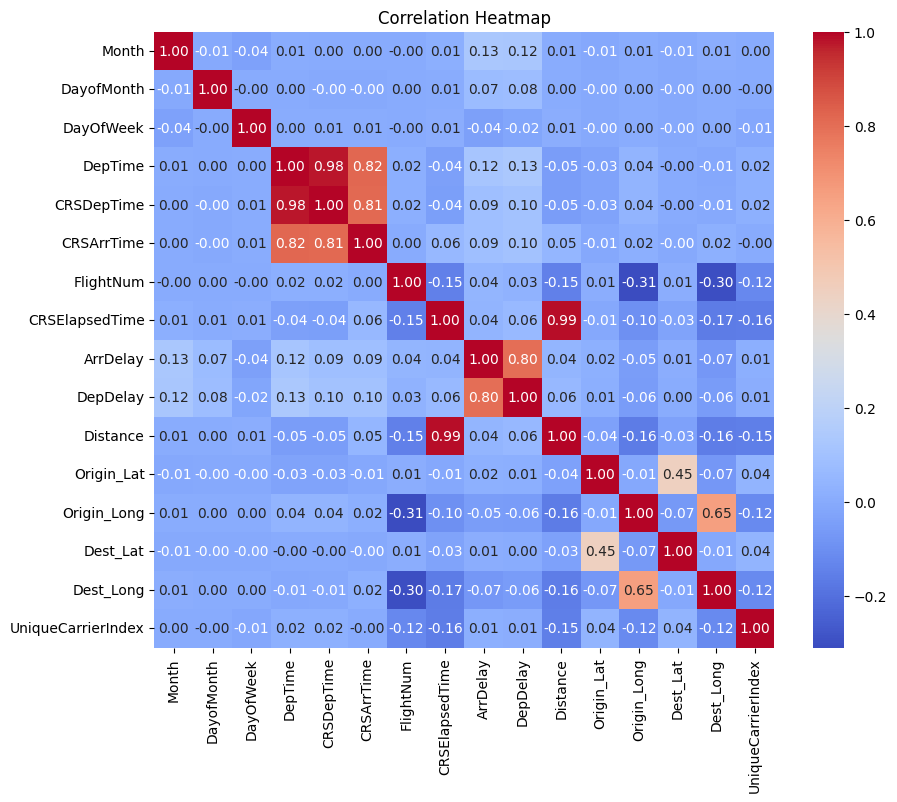

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert the correlation matrix to a Pandas DataFrame for visualization
corr_df = pd.DataFrame(corr_matrix.toArray(), columns=numerical_cols, index=numerical_cols)

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [49]:
#We drop some columns that are higly correlated with another

final_df = final_df.drop("CRSElapsedTime","CRSElapsedTime","CRSArrTime","CRSDepTime")

final_df.printSchema()

root
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- Origin_Lat: double (nullable = true)
 |-- Origin_Long: double (nullable = true)
 |-- Dest_Lat: double (nullable = true)
 |-- Dest_Long: double (nullable = true)
 |-- UniqueCarrierIndex: double (nullable = false)
 |-- UniqueCarrierVec: vector (nullable = true)


## Variable creation

# Modeling

In [50]:
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

In [51]:
# Assuming your target variable is "ArrDelay" and your feature columns are selected
feature_columns = ["Month", "DayofMonth", "DayOfWeek", "DepTime", "FlightNum", "DepDelay", "Distance", "Origin_Lat", "Origin_Long", "Dest_Lat", "Dest_Long", "UniqueCarrierIndex"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_data = assembler.transform(final_df)

In [52]:
train_data, test_data = assembled_data.randomSplit([0.7, 0.3], seed=123)

In [55]:
lr = LinearRegression(featuresCol="features", labelCol="ArrDelay",regParam=0.01)
lr_model = lr.fit(train_data)


24/01/07 23:26:35 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/07 23:26:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/07 23:26:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/07 23:26:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/07 23:26:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/07 23:26:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/07 23:26:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/07 23:26:36 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/07 23:26:36 WARN RowBasedKeyValueBatch: Calling spill() on

In [56]:
test_results = lr_model.evaluate(test_data)

# Print evaluation metrics
print("Root Mean Squared Error (RMSE):", test_results.rootMeanSquaredError)
print("R-squared (R2):", test_results.r2)

24/01/07 23:57:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/07 23:57:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/07 23:57:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/07 23:57:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/07 23:57:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/07 23:57:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/07 23:57:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/07 23:57:30 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
24/01/07 23:57:30 WARN RowBasedKeyValueBatch: Calling spill() on

Root Mean Squared Error (RMSE): 16.680207354746845
R-squared (R2): 0.5918789628228565


# Validation

##Close the context

In [ ]:
spark.stop()